<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/measurePerformance/DUDL_measurePerformance_example2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

import copy

import sklearn.metrics as skm

# Import and process the data

In [2]:
# Import dataset
mnist_dataset = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'), delimiter=',')

#Extract labels (number IDs) and remove from data
labels = mnist_dataset[:, 0]
data   = mnist_dataset[:, 1:]

# Normalize the data to a range of [0, 1]
data_norm = data / np.max(data)

In [3]:
# Convert to tensor
data_tensor   = torch.tensor(data_norm).float()
labels_tensor = torch.tensor(labels).long()

#  Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = \
    train_test_split(data_tensor, labels_tensor, test_size=0.1)

# Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data, test_labels)

# Translate into Dataloader objects
batch_size   = 32
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                          shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                          batch_size=test_data_set.tensors[0].shape[0])

# Create the DL model

In [4]:
def create_the_MNIST_net():
    """"
    FFN_WEIGHTHISTOGRAMS | MODEL_PERFORM_APRF_WINE
    """
    class mnist_net(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 64)

            # Hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # Output layer
            self.output = nn.Linear(32, 10)

        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))

            return self.output(x)
        
    # Create the model instance
    net = mnist_net()

    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    return net, loss_func, optimizer


# Create a function that trains the model

In [5]:
def train_the_model():
    """
    MODEL_PERFORM_APRF_MNIST
    """
    
    num_epochs = 10

    # Create a new model
    net, loss_func, optimizer = create_the_MNIST_net()

    # Initialize
    losses    = torch.zeros(num_epochs)
    train_acc = []
    test_acc  = []

    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Loop over training data batches
        batch_acc  = []
        batch_loss = [] 

        for X, y in train_loader:
            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batch_loss.append(loss.item())

            # Compute accuracy
            matches = torch.argmax(y_hat, axis=1) == y       # Booleans (True/False)
            matches_numeric = matches.float()                # Convert to numbers (1/0)
            accuracy_pct = 100 * torch.mean(matches_numeric) # Average and *100
            batch_acc.append(accuracy_pct)                   # Add to list of accuracies
        # End of batch loop.

        # Get the average training accuracy of the batches
        train_acc.append(np.mean(batch_acc))

        # The average losses accross the batches
        losses[epoch_i] = np.mean(batch_loss)

        # Test accuracy
        X, y = next(iter(test_loader)) # Extract X, y from dataloader
        with torch.no_grad():
            y_hat = net(X)
        test_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()))

    # End epochs

    return train_acc, test_acc, losses, net

# Run the model and show the results!

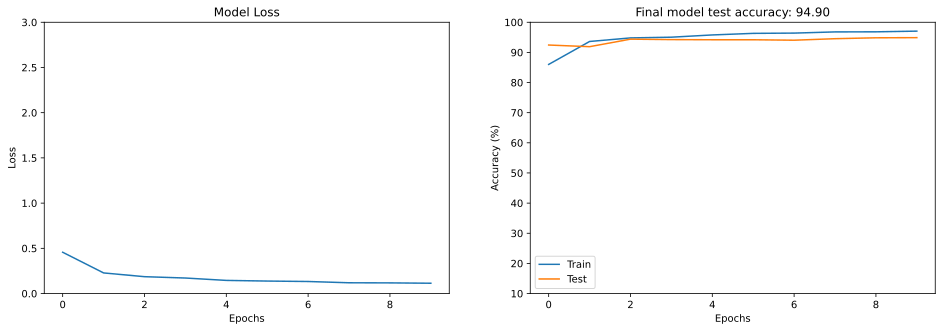

In [6]:
# Build and train the model
train_acc, test_acc, losses, net = train_the_model()

# Visualization starts here
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model Loss')

ax[1].plot(train_acc, label='Train')
ax[1].plot(test_acc,  label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model test accuracy: {test_acc[-1]:.2f}')
ax[1].legend()

plt.show()

# Compute the performance measures on the train and test data

In [7]:
# Predicted digits for training data
y_hat             = net(train_loader.dataset.tensors[0])
train_predictions = torch.argmax(y_hat, axis=1)

# Predictions for test data
y_hat             = net(test_loader.dataset.tensors[0])
test_predictions  = torch.argmax(y_hat, axis=1)

In [ ]:
# Brief aside on computing precision et al. in multiclass data:
# There are now 10 classes, so there are 10 precision values.


## option 1: compute precision for each class (each number)
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average=None)

## option 2: compute average precision, weighted by N
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='weighted')

## option 3: compute average precision, unweighted (same as 'weighted' if category N's are equal)
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='macro')

In [8]:
# Initialize vectors
train_metrics = [0, 0, 0, 0]
test_metrics  = [0, 0, 0, 0]

# Training
train_metrics[0] = skm.accuracy_score(y_true=train_loader.dataset.tensors[1],  y_pred=train_predictions)
train_metrics[1] = skm.precision_score(y_true=train_loader.dataset.tensors[1], y_pred=train_predictions, 
                                        average='weighted')
train_metrics[2] = skm.recall_score(y_true=train_loader.dataset.tensors[1],    y_pred=train_predictions, 
                                        average='weighted')
train_metrics[3] = skm.f1_score(y_true=train_loader.dataset.tensors[1],        y_pred=train_predictions, 
                                        average='weighted')

# Test
test_metrics[0] = skm.accuracy_score(y_true=test_loader.dataset.tensors[1],  y_pred=test_predictions)
test_metrics[1] = skm.precision_score(y_true=test_loader.dataset.tensors[1], y_pred=test_predictions, 
                                        average='weighted')
test_metrics[2] = skm.recall_score(y_true=test_loader.dataset.tensors[1],    y_pred=test_predictions,
                                        average='weighted')
test_metrics[3] = skm.f1_score(y_true=test_loader.dataset.tensors[1],        y_pred=test_predictions, 
                                        average='weighted')

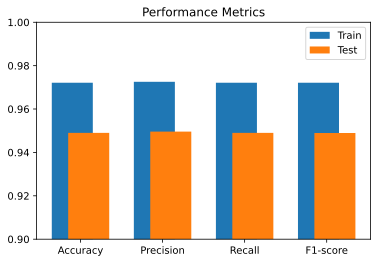

In [9]:
plt.bar(x=np.arange(4) - 0.1, height=train_metrics, width=0.5)
plt.bar(x=np.arange(4) + 0.1, height=test_metrics,  width=0.5)
plt.xticks([0, 1, 2, 3], ['Accuracy', 'Precision', 'Recall', 'F1-score'])
plt.ylim([0.9, 1])
plt.legend(['Train', 'Test'])
plt.title('Performance Metrics')
plt.show()

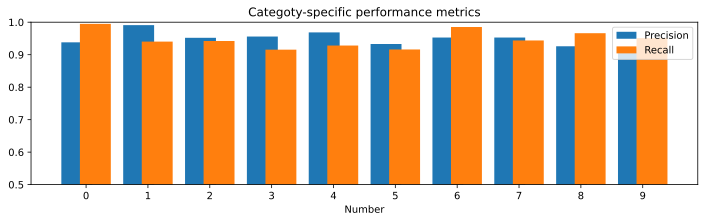

In [12]:
# Bar graphs of class-specific precision and recall for test data

precision = skm.precision_score(y_true=test_loader.dataset.tensors[1], y_pred=test_predictions, average=None)
recall    = skm.recall_score   (y_true=test_loader.dataset.tensors[1], y_pred=test_predictions, average=None)

fig = plt.figure(figsize=(12, 3))
plt.bar(x=np.arange(10) - 0.15, height=precision, width=0.5)
plt.bar(x=np.arange(10) + 0.15, height=recall,    width=0.5)
plt.xticks(range(10), range(10))
plt.ylim([0.5, 1])
plt.xlabel('Number')
plt.legend(['Precision', 'Recall'])
plt.title('Categoty-specific performance metrics')
plt.show()


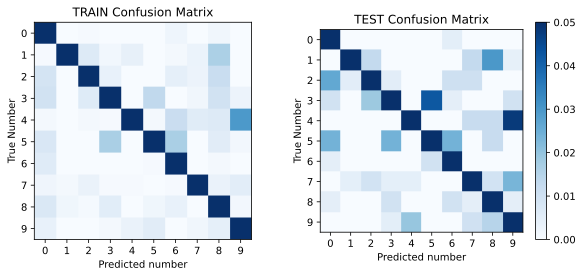

In [11]:
# CONFUSION MATRICES
train_conf  = skm.confusion_matrix(y_true=train_loader.dataset.tensors[1], y_pred=train_predictions, normalize='true')
test_conf   = skm.confusion_matrix(y_true=test_loader.dataset.tensors[1],  y_pred=test_predictions,  normalize='true')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# During TRAIN
ax[0].imshow(train_conf, 'Blues', vmax=0.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_xlabel('Predicted number')
ax[0].set_ylabel('True Number')
ax[0].set_title('TRAIN Confusion Matrix')

# During TEST
a = ax[1].imshow(test_conf, 'Blues', vmax=0.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_xlabel('Predicted number')
ax[1].set_ylabel('True Number')
ax[1].set_title('TEST Confusion Matrix')

fig.colorbar(a)
plt.show()


# Additional explorations

In [ ]:
# 1) The Adam optimizer is pretty amazing, isn't it? Change the code to get the overall test accuracy between 50% and 80%.
#    You can consider changing the optimizer, learning rate, and number of epochs. Then show the performance metrics.
#    Are there systematic difficulties with some numbers, or simply a general decline in performance overall?
# 
# 2) Are the y-axis and color-limits still appropriate? Modify the visualization code so that the graphs are adaptive
#    to the numerical values of the performance metrics and confusion matrices.
#    